### Importing libraries, choosing parameters for picture display

In [2]:
# version check (should be 18 or up for all the libraries to work, otherwise need to update sklearn)

import sklearn
print(sklearn.__version__)

0.18.1


In [3]:
# python (not ml-specific) libraries
from __future__ import division
from datetime import datetime
import time
import math
import numpy as np
from numpy import linalg as LA

#data manipulation - pandas
import pandas as pd

#prediction related libraries
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#plotting
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

### Read data and primary adaptation of features

In [4]:
data = pd.read_csv('cori_jobs_summary.csv')
print(data.shape)
print(data.head())

(5802123, 13)
       jobid user account  num_nodes partition     qos  wallclock_requested  \
0  1483.cori  dmj   mpccc          1     debug  normal                  300   
1  1484.cori  dmj   mpccc          2     debug  normal                  300   
2  1485.cori  dmj   mpccc          2     debug  normal                  300   
3  1694.cori  dmj   mpccc          1     debug  normal                  300   
4  1695.cori  dmj   mpccc          1     debug  normal                  300   

       queued       start  completion  wallclock  raw_secs hostname  
0  1443306538  1443306538  1443306547          9       288     cori  
1  1443307275  1443307275  1443307321         46      1472     cori  
2  1443307314  1443307314  1443307323          9       288     cori  
3  1443484039  1443484039  1443484040          1        32     cori  
4  1443484073  1443484073  1443484074          1        32     cori  


In [5]:
# missing values check - no missing values
data.isnull().any(axis=0)

jobid                  False
user                   False
account                False
num_nodes              False
partition              False
qos                    False
wallclock_requested    False
queued                 False
start                  False
completion             False
wallclock              False
raw_secs               False
hostname               False
dtype: bool

In [6]:
# Queued -> date -> hour (0 - 23) and day of the week (0 - 6 is Monday - Sunday)

data['date'] = pd.to_datetime(data['queued'],unit='s')   
data.date = data.date.dt.tz_localize('UTC').dt.tz_convert('America/Los_Angeles')
data['hour'] = data['date'].apply(lambda x: x.hour)
data['weekday'] = data['date'].apply(lambda x: x.weekday())

print(data.head())                                                                               

       jobid user account  num_nodes partition     qos  wallclock_requested  \
0  1483.cori  dmj   mpccc          1     debug  normal                  300   
1  1484.cori  dmj   mpccc          2     debug  normal                  300   
2  1485.cori  dmj   mpccc          2     debug  normal                  300   
3  1694.cori  dmj   mpccc          1     debug  normal                  300   
4  1695.cori  dmj   mpccc          1     debug  normal                  300   

       queued       start  completion  wallclock  raw_secs hostname  \
0  1443306538  1443306538  1443306547          9       288     cori   
1  1443307275  1443307275  1443307321         46      1472     cori   
2  1443307314  1443307314  1443307323          9       288     cori   
3  1443484039  1443484039  1443484040          1        32     cori   
4  1443484073  1443484073  1443484074          1        32     cori   

                       date  hour  weekday  
0 2015-09-26 15:28:58-07:00    15        5  
1 2015-0

In [7]:
#define future labels:
#1) 'wait time' = 'start time' - 'queued time'
#2) 'discrete wait time' = 0 1 2 3 - 4 quantiles of 'wait time' (0 = short wait time, 3 = very long wait time)


# drop 'cori' as the same for all data; drop a single observation that potentially contains an error 
#(start time is earlier than queued time)


data['wait_time'] = data['start'] - data['queued']
data['discrete_wait_time'] = pd.qcut(data['wait_time'], 4, labels=[0,1,2,3])

data = data.drop('hostname', axis = 1)
data['wrong'] = ((data['start'] < data['queued']) | (data['completion'] < data['start']))
list_of_errors = data.index[data['wrong']].tolist()
for i in list_of_errors:
    data = data.drop([i])
data = data.drop(['wrong'], axis = 1)


print(data.shape)

(5802122, 17)


## Statistics and visualization

count    5.802122e+06
mean     5.149907e+04
std      1.439617e+05
min      0.000000e+00
25%      1.490000e+02
50%      4.927000e+03
75%      3.811100e+04
max      1.614046e+07
Name: wait_time, dtype: float64


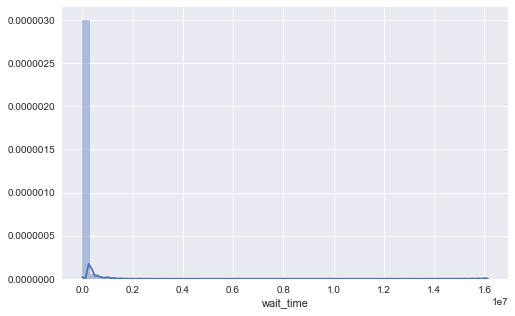

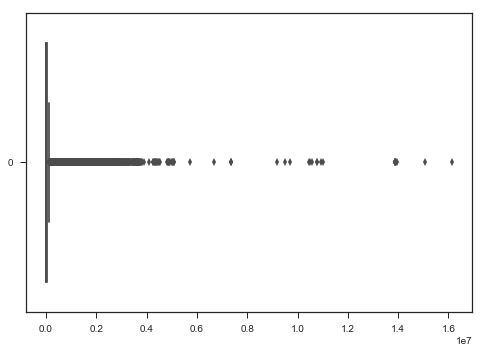

In [8]:
# wait times distribution has a heavy tail - outliers with very long wait 
#(we say this as median << mean and grafically)

print(data['wait_time'].describe())

sns.distplot(data.wait_time)
plt.show()

sns.set(style="ticks")
sns.boxplot(data = data.wait_time, orient="h")
plt.show()

(4351607, 17)


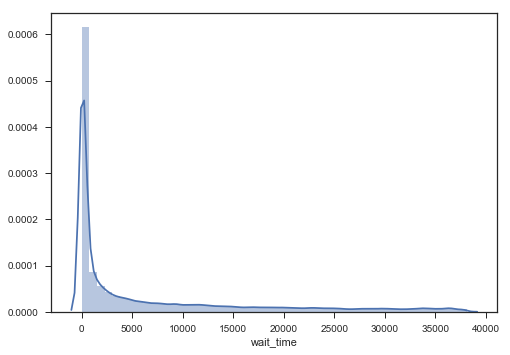

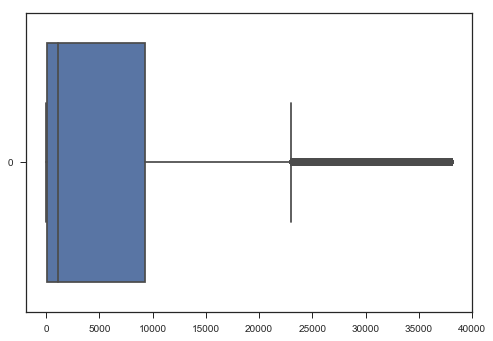

In [9]:
# we can see outliers better if we delete top 25% of longest waits
# grey tail in the boxplot below is what seaborn automatically determines to be outliers 

data_noout = data[data['wait_time'] <= 3.811100e+04]
print(data_noout.shape)
sns.distplot(data_noout.wait_time)
plt.show()

sns.set(style="ticks")
sns.boxplot(data = data_noout.wait_time, orient="h")
plt.show()

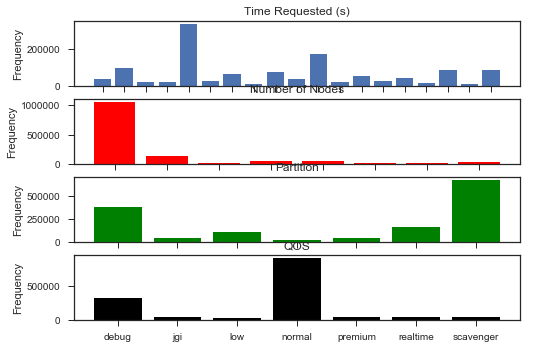

In [10]:
# Jobs where the wait time is less or equal to min_wait (five minutes in this case)
min_wait = 10
fast_jobs =  data[data['discrete_wait_time'] == 0]

plt.subplot(411)
by_wait_temp = fast_jobs.groupby('wallclock_requested').size()
limit = 10000
by_wait = by_wait_temp[by_wait_temp > limit]
xticks1 = list(by_wait.keys())
x1 = np.arange(0., len(xticks1), 1)
plt.rcParams.update({'font.size': 20})
plt.bar(x1,list(by_wait.values))
plt.ylabel("Frequency")
plt.title("Time Requested (s)")
plt.xticks(x1,xticks1)

plt.subplot(412)
by_num_nodes_temp =  fast_jobs.groupby('num_nodes').size()
limit2 = 10000
by_num_nodes = by_num_nodes_temp[by_num_nodes_temp > limit2]
xticks2 = list(by_num_nodes.keys())
x2 = np.arange(0., len(xticks2), 1)
plt.rcParams.update({'font.size': 20})
plt.bar(x2,list(by_num_nodes.values), color = "red")
plt.xticks(x2,xticks2)
plt.ylabel("Frequency")
plt.title("Number of Nodes")

plt.subplot(413)
by_part_temp = fast_jobs.groupby('partition').size()
limit3 = 10000
by_part = by_part_temp[by_part_temp > limit3]
xticks3 = list(by_part.keys())
x3 = np.arange(0., len(xticks3), 1)
plt.rcParams.update({'font.size': 20})
plt.bar(x3,list(by_part.values), color = "green")
plt.xticks(x3,xticks3)
plt.ylabel("Frequency")
plt.title("Partition")

plt.subplot(414)
by_qos_temp = fast_jobs.groupby('qos').size()
limit4 = 10000
by_qos = by_qos_temp[by_qos_temp > limit4]
xticks4 = list(by_qos.keys())
x4 = np.arange(0., len(xticks4), 1)
plt.rcParams.update({'font.size': 20})
plt.bar(x4,list(by_qos.values), color = "black")
plt.xticks(x4,xticks4)
plt.ylabel("Frequency")
plt.title("QOS")

plt.show()

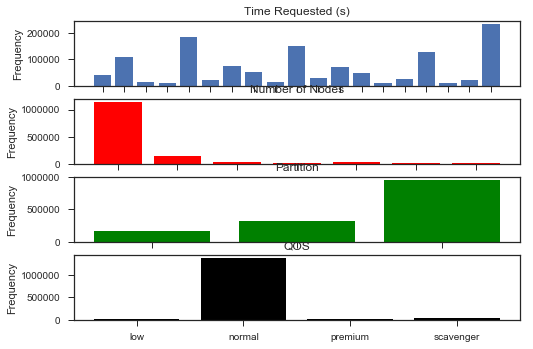

In [11]:
# Jobs where the wait time is less or equal to min_wait (five minutes in this case)
min_wait = 10
fast_jobs =  data[data['discrete_wait_time'] == 3]

plt.subplot(411)
by_wait_temp = fast_jobs.groupby('wallclock_requested').size()
limit = 10000
by_wait = by_wait_temp[by_wait_temp > limit]
xticks1 = list(by_wait.keys())
x1 = np.arange(0., len(xticks1), 1)
plt.rcParams.update({'font.size': 20})
plt.bar(x1,list(by_wait.values))
plt.ylabel("Frequency")
plt.title("Time Requested (s)")
plt.xticks(x1,xticks1)

plt.subplot(412)
by_num_nodes_temp =  fast_jobs.groupby('num_nodes').size()
limit2 = 10000
by_num_nodes = by_num_nodes_temp[by_num_nodes_temp > limit2]
xticks2 = list(by_num_nodes.keys())
x2 = np.arange(0., len(xticks2), 1)
plt.rcParams.update({'font.size': 20})
plt.bar(x2,list(by_num_nodes.values), color = "red")
plt.xticks(x2,xticks2)
plt.ylabel("Frequency")
plt.title("Number of Nodes")

plt.subplot(413)
by_part_temp = fast_jobs.groupby('partition').size()
limit3 = 10000
by_part = by_part_temp[by_part_temp > limit3]
xticks3 = list(by_part.keys())
x3 = np.arange(0., len(xticks3), 1)
plt.rcParams.update({'font.size': 20})
plt.bar(x3,list(by_part.values), color = "green")
plt.xticks(x3,xticks3)
plt.ylabel("Frequency")
plt.title("Partition")

plt.subplot(414)
by_qos_temp = fast_jobs.groupby('qos').size()
limit4 = 10000
by_qos = by_qos_temp[by_qos_temp > limit4]
xticks4 = list(by_qos.keys())
x4 = np.arange(0., len(xticks4), 1)
plt.rcParams.update({'font.size': 20})
plt.bar(x4,list(by_qos.values), color = "black")
plt.xticks(x4,xticks4)
plt.ylabel("Frequency")
plt.title("QOS")

plt.show()

### Best time of the day to submit a job on nersc

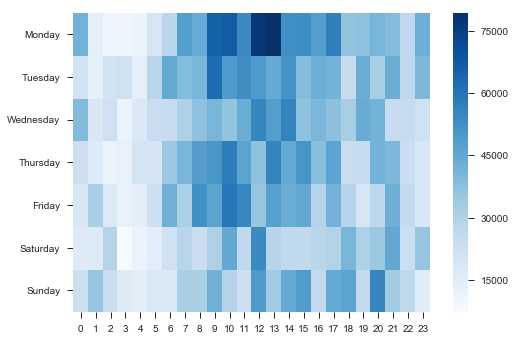

In [12]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# visualize total number of jobs submitted each hour every day (over all data)
aa = data.pivot_table(['wait_time'], ['weekday', 'hour'], aggfunc='count')
all_table_stats = []
for i in range(0,7):
        all_table_stats.append([])
        for j in range(0,24):
            all_table_stats[i].append(aa.iat[i*24+j, 0])
sns.heatmap(all_table_stats, yticklabels = weekdays, cmap = "Blues")
plt.show()

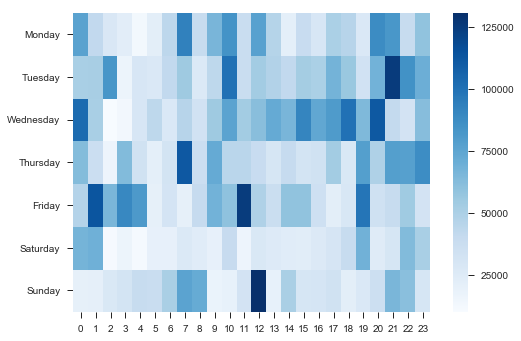

In [13]:
# mean wait time per hour per weekday over all jobs 
aa = data.pivot_table(['wait_time'], ['weekday', 'hour'], aggfunc='mean')
table_stats = []
for i in range(0,7):
        table_stats.append([])
        for j in range(0,24):
            table_stats[i].append(aa.iat[i*24+j, 0])
sns.heatmap(table_stats, yticklabels = weekdays, cmap = "Blues")
plt.show()

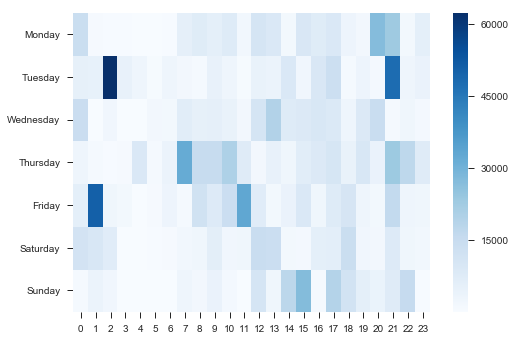

In [14]:
# median wait time per hour per weekday over all jobs 
# shows clearer trend (shorter wait time during night hours), as median is less prone to outliers 
#(few eexceptionally long wait times) than mean

aa = data.pivot_table(['wait_time'], ['weekday', 'hour'], aggfunc='median')
table_stats = []
for i in range(0,7):
        table_stats.append([])
        for j in range(0,24):
            table_stats[i].append(aa.iat[i*24+j, 0])
sns.heatmap(table_stats, yticklabels = weekdays, cmap = "Blues")
plt.show()

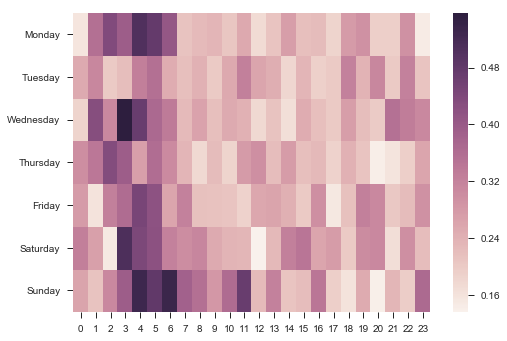

In [15]:
# fraction of low wait jobs (in the bottom 25%-quantile) per hour per day
# more such jobs during night hours and on Sunday

short_wait_time = data[data['discrete_wait_time'] == 0]
aa = short_wait_time.pivot_table(['jobid'], ['weekday', 'hour'], aggfunc='count')
table_stats = []
for i in range(0,7):
        table_stats.append([])
        for j in range(0,24):
            table_stats[i].append(aa.iat[i*24+j, 0])
for i in range(0,7):
    for j in range(0,24):
        table_stats[i][j] /= all_table_stats[i][j]
sns.heatmap(table_stats, yticklabels = weekdays)
plt.show()

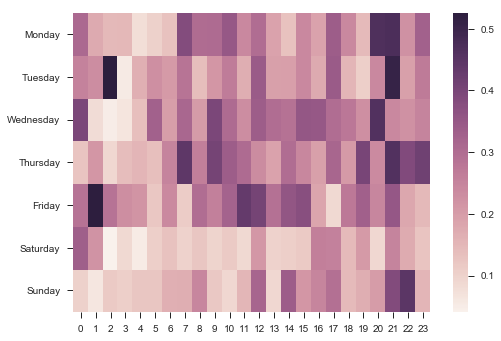

In [16]:
# fraction of slow jobs (in the top 25%-quantile) per hour per day
# trend is less clear, but more in evenings and weekdays
# medium 2 quantiles does not show distinctive changes in frequency over different weekdays and daytimes


short_wait_time = data[data['discrete_wait_time'] == 3]
aa = short_wait_time.pivot_table(['jobid'], ['weekday', 'hour'], aggfunc='count')
table_stats = []
for i in range(0,7):
        table_stats.append([])
        for j in range(0,24):
            table_stats[i].append(aa.iat[i*24+j, 0])
for i in range(0,7):
    for j in range(0,24):
        table_stats[i][j] /= all_table_stats[i][j]
sns.heatmap(table_stats, yticklabels = weekdays)
plt.show()

### Do users often overestimate wallclock time requested? (Yes!)

In [17]:
# actual time taken statistics
data['wallclock'].describe()

count    5.802122e+06
mean     8.778510e+03
std      2.393879e+04
min      0.000000e+00
25%      1.380000e+02
50%      9.990000e+02
75%      4.760000e+03
max      3.664500e+05
Name: wallclock, dtype: float64

In [18]:
# almost 50% of requests overestimate wallclock requested time in 7 times

data_overestimates = data[data['wallclock_requested'] > 7*data['wallclock']]
print(data_overestimates['jobid'].count()/data['jobid'].count())

0.490333191891


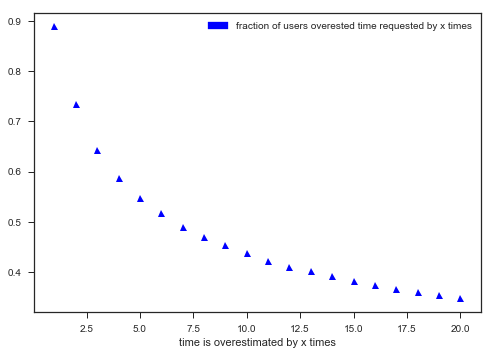

In [19]:
# i-th point shows (on y axis) fraction of people that overestimate wallclock needed by i times

# (89% of user overestimate wallclock requested)
# (about 40% of people overestimated by about 14 times)

timestamps = 20
total = data['jobid'].count()
fractions = [0]*timestamps
for k in range(1,timestamps + 1):
    fractions[k-1] = data[data['wallclock_requested'] > k*data['wallclock']]['wait_time'].count()
    fractions[k-1] /= total
    
blue_patch = mpatches.Patch(color='blue', label='fraction of users overested time requested by x times')
plt.legend(handles=[blue_patch])
plt.xlabel('time is overestimated by x times')
plt.plot(range(1,timestamps+1), fractions, 'b^')
plt.show()


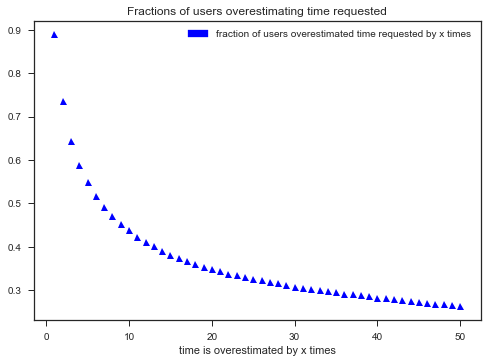

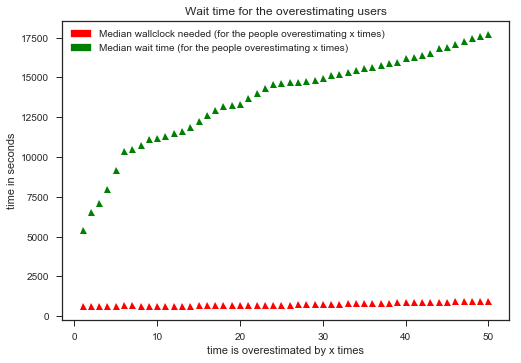

In [20]:
# statistics for the jobs requiring 5 to 20 min to execute, 1194927 users in this sample

data_5to20 = data[(data['wallclock'] > 300) & (data['wallclock'] < 1200)]

timestamps = 50

wallclocks = [0]*timestamps
waittimes = [0]*timestamps
fractions = [0]*timestamps

for k in range(1,timestamps + 1):
    fractions[k-1] = data[data['wallclock_requested'] > k*data['wallclock']]['wait_time'].count()
    fractions[k-1] /= total

for k in range(1,timestamps + 1):
    waittimes[k-1] = data_5to20[data_5to20['wallclock_requested'] > k*data_5to20['wallclock']]['wait_time'].median()
    wallclocks[k-1] = data_5to20[data_5to20['wallclock_requested'] > k*data_5to20['wallclock']]['wallclock'].median()
    
#plotting

plt.title('Fractions of users overestimating time requested')
blue_patch = mpatches.Patch(color='blue', label='fraction of users overestimated time requested by x times')
plt.legend(handles=[blue_patch])
plt.xlabel('time is overestimated by x times')
plt.plot(range(1,timestamps+1), fractions, 'b^')
plt.show()

plt.title('Wait time for the ''overestimating'' users')
red_patch = mpatches.Patch(color='red', label='Median wallclock needed (for the people overestimating x times)')
green_patch = mpatches.Patch(color='green', label='Median wait time (for the people overestimating x times)')
plt.legend(handles=[red_patch, green_patch])
plt.plot(range(1,timestamps+1), waittimes, 'g^', range(1,timestamps+1), wallclocks, 'r^')
plt.xlabel('time is overestimated by x times')
plt.ylabel('time in seconds')
plt.show()


## Wait time prediction 

In [21]:
# feature selection

prediction_columns =  (data['num_nodes']).to_frame('num_nodes')
prediction_columns['qos'] = data['qos']
prediction_columns['weekday'] = data['weekday']
prediction_columns['hour'] = data['hour']
prediction_columns['qos'] = data['qos']
prediction_columns['partition'] = data['partition']
prediction_columns['wallclock_requested'] = data['wallclock_requested']/data['wallclock_requested'].mean()
prediction_columns = pd.get_dummies(prediction_columns)
prediction_columns['discrete_wait_time'] = data['discrete_wait_time']

#all features that will be used for prediction and discrete_wait_time = label
print(prediction_columns.shape)
prediction_columns.isnull().any(axis=0)

(5802122, 38)


num_nodes                        False
weekday                          False
hour                             False
wallclock_requested              False
qos_burstbuffer                  False
qos_debug                        False
qos_interactive                  False
qos_jgi                          False
qos_justone                      False
qos_long                         False
qos_low                          False
qos_normal                       False
qos_preemptable                  False
qos_premium                      False
qos_realtime                     False
qos_scavenger                    False
qos_serialize                    False
qos_system                       False
qos_wayearlyuser                 False
partition_debug                  False
partition_debug_knl              False
partition_haswell_interactive    False
partition_immediate              False
partition_jgi                    False
partition_knl                    False
partition_knl_interactive

In [22]:
# split all data into train and test 

train, test = train_test_split(prediction_columns, test_size=0.2)
print(train.shape)
print(test.shape)
test_size = test.shape[0]

train_labels = train['discrete_wait_time']
train_data = train.drop(['discrete_wait_time'], axis = 1)
test_labels = test['discrete_wait_time']
test_data = test.drop(['discrete_wait_time'], axis = 1)

(4641697, 38)
(1160425, 38)


## 1) Logistic Regression

In [23]:
# Logistic Regression
LR = LogisticRegression()
LR.fit(train_data, train_labels)
prediction_labels = LR.predict(test_data)
print(accuracy_score(test_labels, prediction_labels))

0.390352672512


## 2) KNN

In [24]:
# K Nearest Neighbors
KNN = KNeighborsClassifier()
KNN.fit(train_data, train_labels)
prediction_labels = KNN.predict(test_data)
print(accuracy_score(test_labels, prediction_labels))

0.671842643859


## 3) NB

In [25]:
# Gaussian Naive Bayes Classifier
NB = GaussianNB()
NB.fit(train_data, train_labels)
prediction_labels = NB.predict(test_data)
print(accuracy_score(test_labels, prediction_labels))

0.312671650473


## 4) Classification tree

In [27]:
# quality slightly varies depending on test-train split

clf_tree = DecisionTreeClassifier(max_depth = 41, max_features = 37, random_state=0)
clf_tree.fit(train_data, train_labels)
prediction_labels = clf_tree.predict(test_data)
print(accuracy_score(test_labels, prediction_labels))



0.713518753905


In [28]:
# seach for best parameters - too slow for _my_ computer to do it properly - ranges should be adjusted
# best parameters also seem to be different for different test-train splits

tree_params = {'max_depth': range(20, 61, 20),'max_features': range(12, 38, 10)}
tree_grid = GridSearchCV(clf_tree, tree_params, cv = 3, n_jobs=-1,verbose=True)
tree_grid.fit(train_data, train_labels)



Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  5.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=41,
            max_features=37, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [12, 22, 32], 'max_depth': [20, 40, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [29]:
tree_grid.best_params_

{'max_depth': 40, 'max_features': 22}

In [30]:
accuracy_score(test_labels, tree_grid.predict(test_data))

0.71363939935799381

## 5) Random forest classifier

In [31]:
# did not search for parameters here - too slow for my computer
# auto means choose sqrt(# of features) for each tree, 6 = sqrt(38) in our case

clf = RandomForestClassifier(n_estimators = 60, max_depth = 40, max_features = 'auto', random_state=0)
clf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [32]:
print(accuracy_score(test_labels,clf.predict(test_data)))

0.714468405972


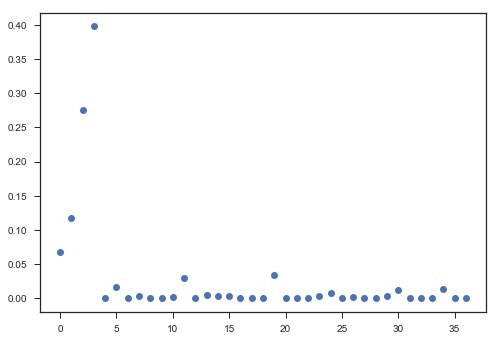

[  6.76100657e-02   1.17896017e-01   2.75925600e-01   3.97922135e-01
   6.59438428e-04   1.59418729e-02   7.35878598e-04   2.69969113e-03
   2.31705840e-07   8.73216563e-05   1.93955713e-03   2.89731642e-02
   4.74677017e-08   5.17118062e-03   3.56959806e-03   3.71765654e-03
   1.13782487e-05   2.29370249e-05   3.80142213e-05   3.45889171e-02
   1.29532003e-04   2.73276617e-04   2.58489926e-07   2.62647825e-03
   7.70017538e-03   9.39178045e-05   1.24196874e-03   1.36747722e-05
   1.28784986e-06   2.88924251e-03   1.22878097e-02   3.98149986e-04
   5.65504758e-04   1.60915306e-07   1.32121510e-02   4.68691508e-04
   5.87016109e-04]


In [33]:
plt.plot(clf.feature_importances_, 'o')
plt.show()
print(clf.feature_importances_)
plt.xlabel('feature id')
plt.ylabel('importance score')